In [9]:
import pandas as pd
import matplotlib.pyplot as plt
from read_csv_file import read_csv_file
file_path = '/Users/remiliascarlet/Desktop/MDP/transfer_learning/burst_data/csv/240729165011-Skyline High School.csv'


In [10]:
df = pd.read_csv(file_path, on_bad_lines='skip')
# if df is not None:
#     print("DataFrame head:\n", df)

dates = df['Date']
times = df['Time']
frequency = df.columns[2:].astype(int)
data = df.iloc[:, 2:]

# print("Dates:\n", dates.head())
# print("Times:\n", times.head())
# print("Frequency (Hz):\n", frequency)
# print("Data:\n", data.head())

High variance columns: []
Low variance rows: [122 123 124 149 150 151 242 276 301 302 303 313 314 315 316 317 318 319
 321 322 323 324 328 330 331 332 352 353 354 369 380 381 386 387 388 389
 390 392 393 394 395 396 397 398 399 400 401 402 403 404 405 406 407 408
 409 410]


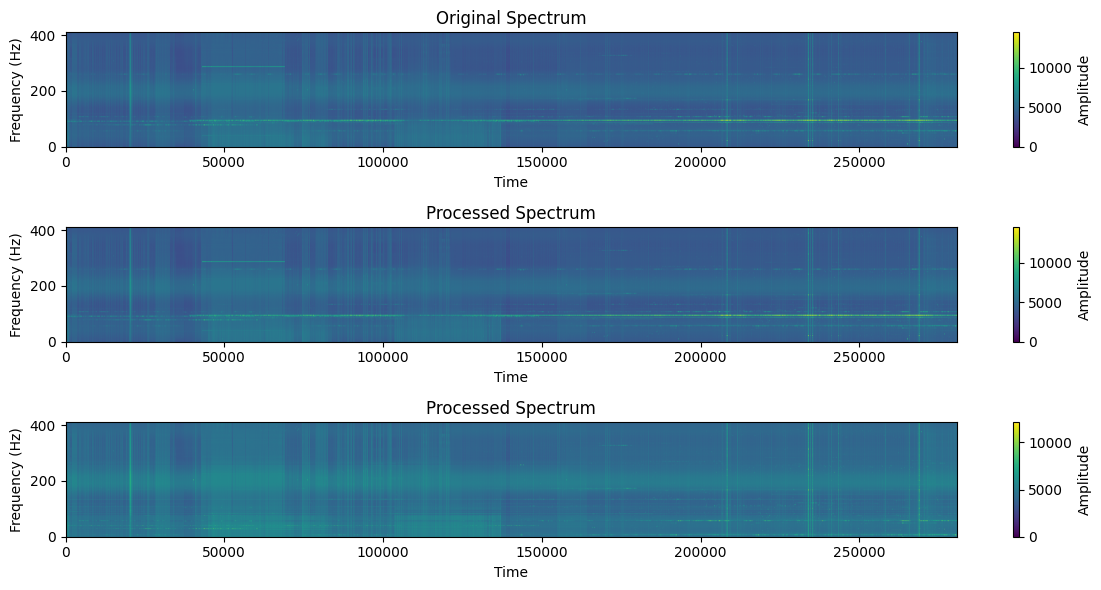

In [11]:
from data_denoise import remove_horizontal_noise, remove_vertical_noise

remove_horizontal_data = remove_horizontal_noise(data, num_std = 15)
removed_data = remove_vertical_noise(remove_horizontal_data)
# removed_data = remove_horizontal_data

plt.figure(figsize=(12, 6))

plt.subplot(3, 1, 1)
plt.imshow(data.T[::-1], aspect='auto', origin='lower', cmap='viridis')
plt.title('Original Spectrum')
plt.xlabel('Time')
plt.ylabel('Frequency (Hz)')
plt.colorbar(label='Amplitude')

plt.subplot(3, 1, 2)
plt.imshow(remove_horizontal_data.T[::-1], aspect='auto', origin='lower', cmap='viridis')
plt.title('Processed Spectrum')
plt.xlabel('Time')
plt.ylabel('Frequency (Hz)')
plt.colorbar(label='Amplitude')

plt.subplot(3, 1, 3)
plt.imshow(removed_data.T[::-1], aspect='auto', origin='lower', cmap='viridis')
plt.title('Processed Spectrum')
plt.xlabel('Time')
plt.ylabel('Frequency (Hz)')
plt.colorbar(label='Amplitude')

plt.tight_layout()
plt.show()

start_index: 19752 end_index: 20718


/Users/remiliascarlet/Desktop/MDP/transfer_learning/radburst_tl/data_preprocessing/data_label.py:188: FutureWarning: The 'axis' keyword in DataFrame.rolling is deprecated and will be removed in a future version. Call the method without the axis keyword instead.
  filtered_mask_df = mask_df.rolling(window=window_size, axis=0, center=True).median()


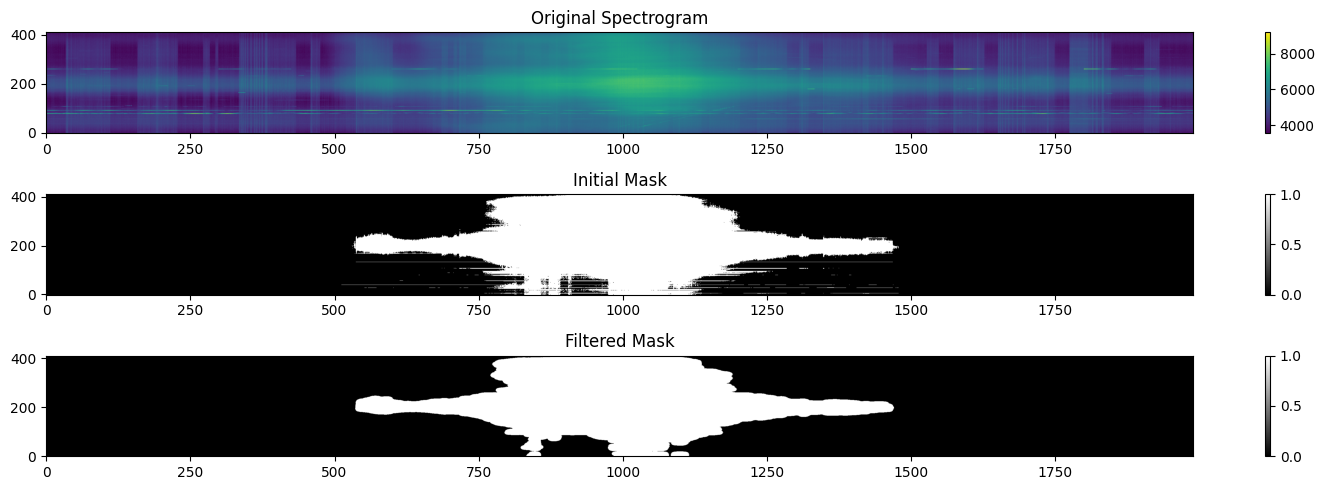

In [13]:
from data_label import time_to_column_indices, create_srb_mask, apply_morphological_operations, blur, apply_rolling_median_filter, intersect_srb_masks
import numpy as np

start_time_str = '17:23:15' # Replace with the actual onset time of your data
end_time_str = '17:24:52' # Replace with the actual offset time of your data

start_index, end_index = time_to_column_indices(times, start_time_str, end_time_str)
print("start_index:", start_index, "end_index:", end_index)

# initial_mask = create_srb_mask(data, start_index, end_index, pct_threshold=25)
initial_mask = create_srb_mask(removed_data, start_index, end_index, pct_threshold=50)
morph_mask = apply_morphological_operations(initial_mask, erosion_radius=10, dilation_radius=10, operation_sequence=['erode', 'dilate'])
filtered_mask = apply_rolling_median_filter(morph_mask, window_size=5)
# final_mask = blur(morph_mask, blur_filter_shape=(5, 5))

undeniosed_mask = create_srb_mask(data, start_index, end_index)
undeniosed_morph_mask = apply_morphological_operations(undeniosed_mask, erosion_radius=2, dilation_radius=10, operation_sequence=['erode', 'dilate'])
undeniosed_filtered_mask = apply_rolling_median_filter(undeniosed_morph_mask, window_size=3)

final_mask = intersect_srb_masks(filtered_mask, undeniosed_filtered_mask)

# Plotting
plotting_data = remove_horizontal_data[(start_index-512):(end_index+512),:]
plotting_initial_mask = initial_mask[(start_index-512):(end_index+512),:]
plotting_filtered_mask = filtered_mask[(start_index-512):(end_index+512),:]

plt.figure(figsize=(15, 5))

plt.subplot(3, 1, 1)
plt.imshow(plotting_data.T[::-1], aspect='auto', cmap='viridis', origin='lower')
plt.title('Original Spectrogram')
plt.colorbar()

plt.subplot(3, 1, 2)
plt.imshow(plotting_initial_mask.T[::-1], aspect='auto', cmap='gray', origin='lower')
plt.title('Initial Mask')
plt.colorbar()

plt.subplot(3, 1, 3)
plt.imshow(plotting_filtered_mask.T[::-1], aspect='auto', cmap='gray', origin='lower')
plt.title('Filtered Mask')
plt.colorbar()

# plt.subplot(4, 1, 4)
# plt.imshow(final_mask.T[::-1], aspect='auto', cmap='gray', origin='lower')
# plt.title('Final Mask (After Morphology and Blur)')
# plt.colorbar()

plt.tight_layout()
plt.show()

#Filtered mask is Best!
using_data = remove_horizontal_data
using_mask = filtered_mask
# using_data = remove_horizontal_data[(start_index-512):(end_index+512), :]
# using_mask = filtered_mask[(start_index-512):(end_index+512), :]
# using_times = times[(start_index-512):(end_index+512)]
# print(using_times)

In [14]:
# Data Slicing

from data_slicing import SpectrogramSlicer

# Initialize the slicer
slicer = SpectrogramSlicer(target_size=(256, 256), overlap_ratio=0.25, random_offset=False)

# Slice the spectrogram and mask
# Note: 'times' is the array of timestamps, 'using_data' is the spectrogram data, and 'using_mask' is the mask data
slices, mask_slices, positions = slicer.slice_spectrogram_time_range(
    spectrogram=using_data.T[::-1],
    time_array=times,
    start_time_str=start_time_str,
    end_time_str=end_time_str,
    mask=using_mask.T[::-1],
    time_padding=0.2,
    is_training=False  # Set to False for deterministic slicing
)

# Output slice information
print(f"Generated {len(slices)} spectrogram slices")
print(f"Slice shape: {slices[0].shape}")
print(f"Mask slice shape: {mask_slices[0].shape}")
print(f"Slice position: {positions}")


Generated 14 spectrogram slices
Slice shape: (256, 256)
Mask slice shape: (256, 256)
Slice position: [(0, 19496), (155, 19496), (0, 19688), (155, 19688), (0, 19880), (155, 19880), (0, 20072), (155, 20072), (0, 20264), (155, 20264), (0, 20456), (155, 20456), (0, 20648), (155, 20648)]


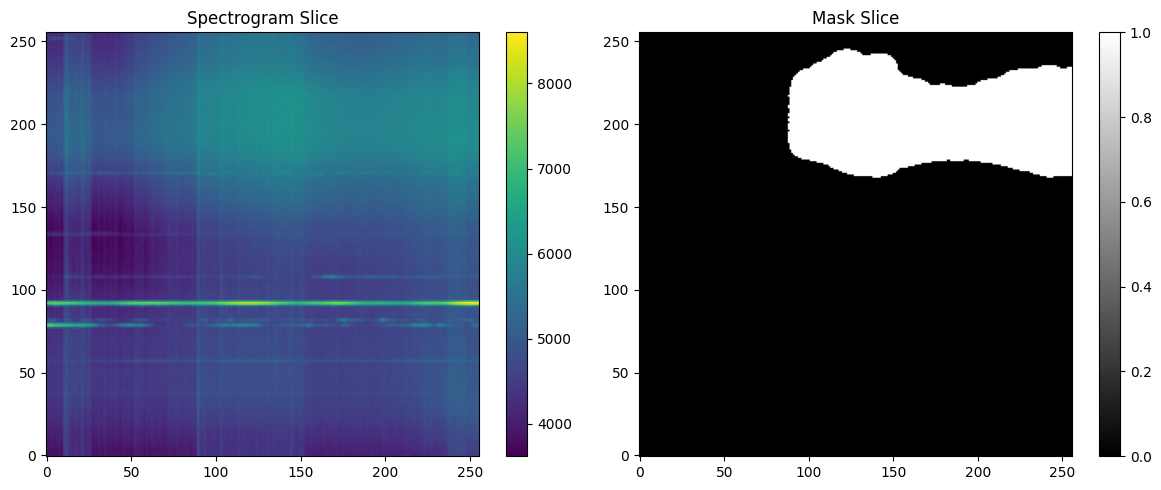

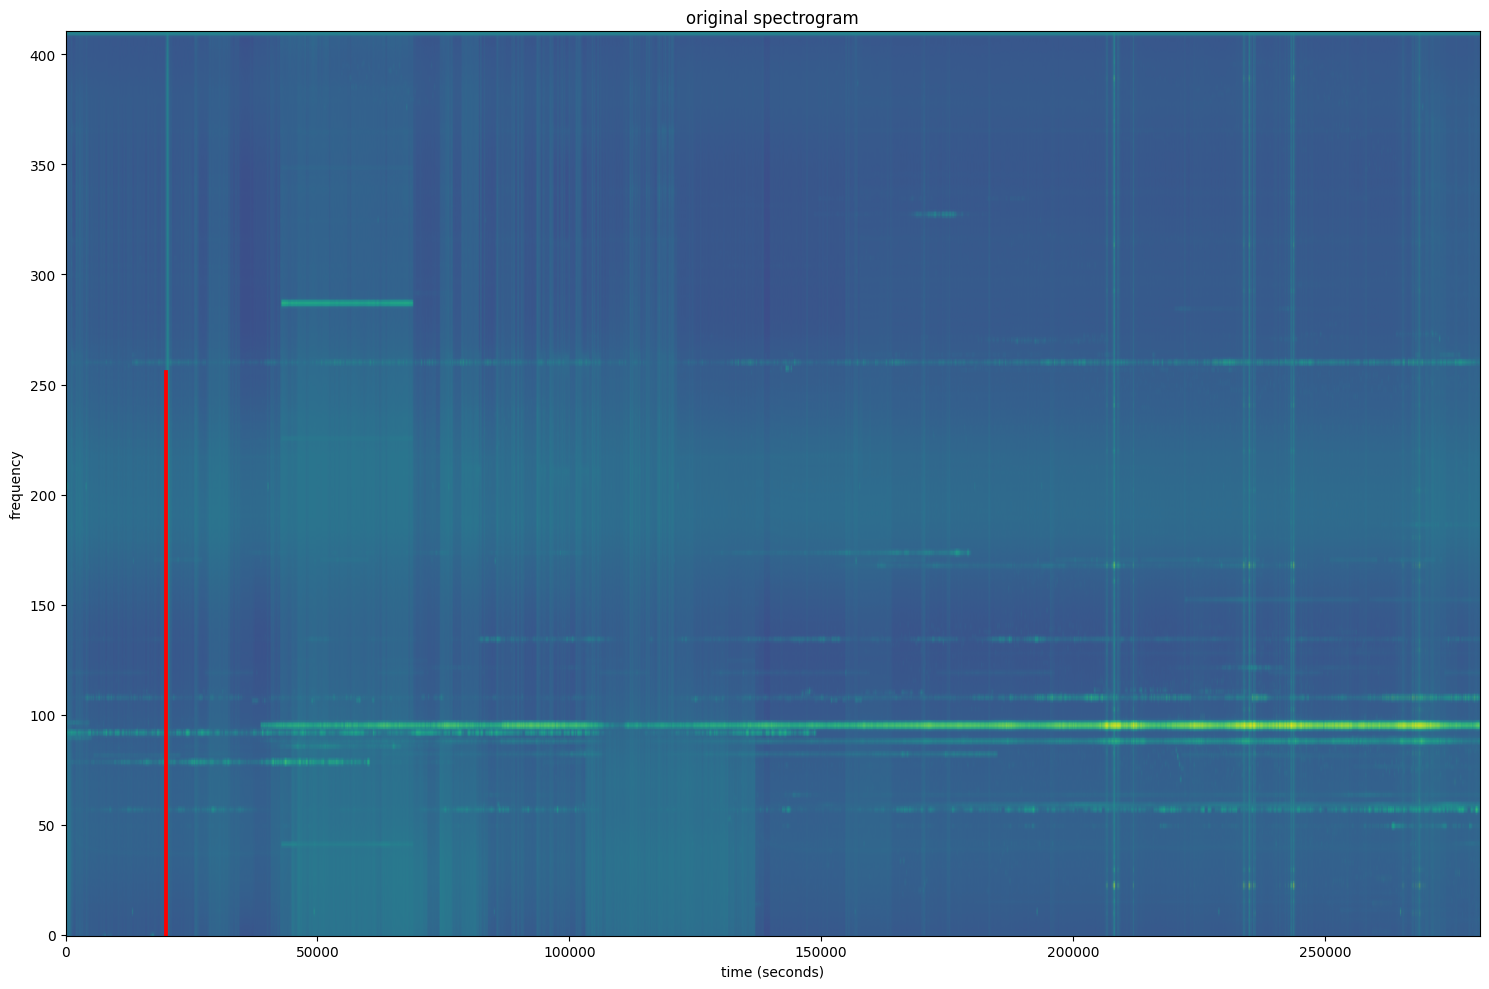

In [15]:

from numpy import min, max
# Optional: Visualize the first slice and its mask

vmin = min(min(using_data))
vmax = max(max(using_data))

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
# plt.imshow(slices[2], aspect='auto', cmap='viridis', origin='lower', vmin=vmin, vmax=vmax)
plt.imshow(slices[2], aspect='auto', cmap='viridis', origin='lower')
plt.title('Spectrogram Slice')
plt.colorbar()

plt.subplot(1, 2, 2)
plt.imshow(mask_slices[2], aspect='auto', cmap='gray', origin='lower')
plt.title('Mask Slice')
plt.colorbar()

plt.tight_layout()
plt.show()

plt.figure(figsize=(15, 10))


plt.imshow(using_data.T[::-1], aspect='auto', cmap='viridis', origin='lower', vmin=vmin, vmax=vmax)
plt.title('original spectrogram')
plt.xlabel('time (seconds)')
plt.ylabel('frequency')

if len(positions) > 0:
    y, x = positions[2]  # positions return (y, x)
    # based on the x, find the start and end time
    
    x_start = times[x]
    if x + slicer.target_width < len(times):
        x_end = times[x + slicer.target_width]
    else:
        x_end = times[-1]
    
    y_start = y
    y_end = y + slicer.target_height

    rect = plt.Rectangle((x, y_start), 256, 256, 
                         linewidth=2, edgecolor='r', facecolor='none')
    plt.gca().add_patch(rect)

plt.tight_layout()
plt.show()

In [16]:
# Optional: Save slices to CSV files
metadata = {
    'date': '20240729', # change to the actual date!!!
    'start_time': start_time_str.replace(':', '')
}
save_dir = '/Users/remiliascarlet/Desktop/MDP/transfer_learning/burst_data/csv/saved_slices'
saved_files = slicer.save_slices_to_csv(
    slices=slices,
    mask_slices=mask_slices,
    save_dir=save_dir,
    naming_format='slice_{meta_date}_y{y}_x{x}_SkylineHS',  # Naming format
    positions=positions,
    metadata=metadata
)

Saved 14 spectrogram slices to /Users/remiliascarlet/Desktop/MDP/transfer_learning/burst_data/csv/saved_slices


In [49]:
# from data_denoise import remove_vertical_noise
from data_label import detect_srb

# cleaned_mask = detect_srb(removed_data)

# plt.subplot(3, 1, 3)
# plt.plot(cleaned_mask, label='Processed Mask', color='orange')
# plt.title('Processed Mask')
# plt.xlabel('Time')
# plt.ylabel('Mask')
# plt.legend()

